<a href="https://colab.research.google.com/github/CIA-Oceanix/DLCourse_MOi_2022/blob/main/notebooks/notebook_PytorchLightning_Forecasting_L63_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook for short-term forecasting using recurrent neural networks and physics-informed networks **: Application to the short-term forecasting of Lorenz-63 dynamics.


In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import os

import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

from sklearn import decomposition

from scipy.integrate import odeint


# **L63 Data simulation**: simulate L63 time series from the known ODE

In [4]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = np.zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx


# Define the parameters
x0 = np.array([8,0,30]) # initial condition
dt = 0.01 # integration time step
T = 200 # number of Lorenz-63 times
sigma = 10
rho = 28
beta = 8/3

# Generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, np.arange(0.01,T,dt), args=(sigma,rho,beta))  
time = np.arange(0.01,T,dt)

# Transform array to tensor
x = torch.from_numpy(x).float()

torch.Size([19999, 3])


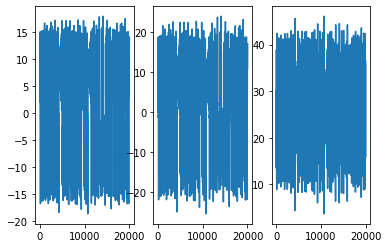

In [5]:
print(x.shape)
plt.figure(1)
for jj in range(0,3):
  plt.subplot(131+jj)
  plt.plot(x[:,jj])

In [6]:
from sklearn.feature_extraction import image

####################################################
## Generation of training and test dataset
## Extraction of time series of dT time steps            
NbTraining = 10000
NbTest     = 2000#256
time_step = 1
dT        = 30
  
# extract subsequences
X_train = image.extract_patches_2d(x[3000:15000:time_step,:],(dT,3),max_patches=NbTraining)
X_test  = image.extract_patches_2d(x[17500::time_step,:],(dT,3),max_patches=NbTest)

X_train      = np.moveaxis(X_train,-1,1)
X_test      = np.moveaxis(X_test,-1,1)


############################################
## normalized data
meanTr          = np.mean(X_train[:]) 
stdTr           = np.std( X_train[:] )

# scale wrt std
x_train = (X_train - meanTr) / stdTr
x_test  = (X_test - meanTr) / stdTr

print('.... MeanTr = %.3f --- StdTr = %.3f '%(meanTr,stdTr))
print('..... Training dataset: %dx%dx%d'%(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
print('..... Test dataset    : %dx%dx%d'%(x_test.shape[0],x_test.shape[1],x_test.shape[2]))


.... MeanTr = 8.410 --- StdTr = 13.766 
..... Training dataset: 10000x3x30
..... Test dataset    : 2000x3x30


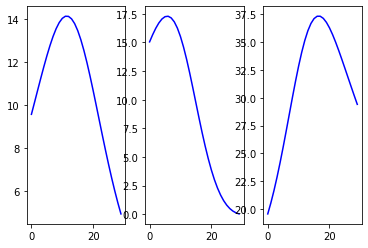

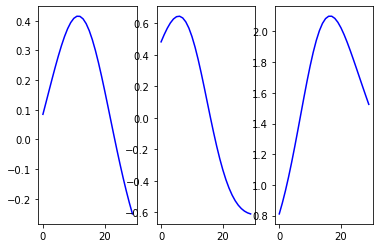

In [7]:
# Visualisation
plt.figure(1)
for jj in range(0,3):
  indjj = 131+jj
  plt.subplot(indjj)
  plt.plot(X_train[20,jj,:],'b-')

plt.figure(2)
for jj in range(0,3):
  indjj = 131+jj
  plt.subplot(indjj)
  plt.plot(x_train[20,jj,:],'b-')

# **Forecasting model definition**: choose yor model (linear AR model), residual MLP, GRU, LSTM, ODE-based parameterization. ** TO DO**: (1) code the LSTM version, (2) replace the Euler-like residual upadte by a Runge-Kutta integration scheme in the MLP ODE scheme 

In [258]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

## linear forecasting model
class linear_regression_nn(torch.nn.Module):
  
  # class initialization
  def __init__(self, input_size, output_size):
      super(linear_regression_nn, self).__init__()
      # fully connected layer with linear activation
      self.fc = torch.nn.Linear(input_size, output_size)
      
  # function to apply the neural network
  def forward(self, x_in, n_step=1):
    x = x_in

    for nn in range(0,n_step):
      x = self.fc(x)

      if nn > 0 :
        x_out = torch.cat((x_out,x.view(-1,3,1)),dim=2)
      else:
        x_out = x.view(-1,3,1)

    return x_out


## MLP architecture (relu)
class mlp_relu_nn(torch.nn.Module):
  
  # class initialization
  def __init__(self, input_size, output_size):
      super(mlp_relu_nn, self).__init__()
      # fully connected layer with linear activation
      self.fc1 = torch.nn.Linear(input_size, 20)
      self.fc2 = torch.nn.Linear(20, output_size)
      self.dt = dt
      
      self.solver = 'rk4' #'euler'#

  # function to apply the neural network
  def _f(self,x):
    return self.fc2( torch.relu( self.fc1(x) ) )

  def _EulerSolver(self, x):
      return x + self.dt * self._f(x)

  def _RK4Solver(self, x):
      k1 = self._f(x)
      x2 = x + 0.5 * self.dt * k1
      k2 = self._f(x2)
    
      x3 = x + 0.5 * self.dt * k2
      k3 = self._f(x3)
        
      x4 = x + self.dt * k3
      k4 = self._f(x4)

      return x + self.dt * (k1+2.*k2+2.*k3+k4)/6.

  def _ode_solver(self,x):
      if self.solver == 'euler' :
        return self._EulerSolver(x)
      else:
        return self._RK4Solver(x)

  def forward(self, x_in, n_step=1):
    x = x_in

    for nn in range(0,n_step):
      x = self._ode_solver(x)
      if nn > 0 :
        x_out = torch.cat((x_out,x.view(-1,3,1)),dim=2)
      else:
        x_out = x.view(-1,3,1)

    return x_out

## MLP architecture (polynomial)
class mlp_poly_nn(torch.nn.Module):
  
  # class initialization
  def __init__(self, input_size, output_size,hidden_size):
      super(mlp_poly_nn, self).__init__()
      # fully connected layer with linear activation
      self.fc1 = torch.nn.Linear(input_size, hidden_size, bias=False)
      self.fc2 = torch.nn.Linear(input_size, hidden_size, bias=False)
      self.fc3 = torch.nn.Linear(input_size, hidden_size)
      self.fc4 = torch.nn.Linear(hidden_size, output_size, bias=False)
      self.dt = dt
      
      self.solver = 'rk4'#'euler'#

  # function to apply the neural network
  def _f(self,x):
    return self.fc4( self.fc1(x) + self.fc2(x)*self.fc3(x) )

  def _EulerSolver(self, x):
      return x + self.dt * self._f(x)

  def _RK4Solver(self, x):
      k1 = self._f(x)
      x2 = x + 0.5 * self.dt * k1
      k2 = self._f(x2)
    
      x3 = x + 0.5 * self.dt * k2
      k3 = self._f(x3)
        
      x4 = x + self.dt * k3
      k4 = self._f(x4)

      return x + self.dt * (k1+2.*k2+2.*k3+k4)/6.

  def _ode_solver(self,x):
      if self.solver == 'euler' :
        return self._EulerSolver(x)
      else:
        return self._RK4Solver(x)

  def forward(self, x_in, n_step=1):
    x = x_in

    for nn in range(0,n_step):
      x = self._ode_solver(x)
      if nn > 0 :
        x_out = torch.cat((x_out,x.view(-1,3,1)),dim=2)
      else:
        x_out = x.view(-1,3,1)

    return x_out

## Lorenz parameterization
class lorenz_nn(torch.nn.Module):    
  # class initialization
  def __init__(self,sigma,rho,beta,dt):
      super(lorenz_nn, self).__init__()

      self.sigma = torch.nn.Parameter(torch.Tensor([sigma]), requires_grad=True)
      self.rho   = torch.nn.Parameter(torch.Tensor([rho]), requires_grad=True)
      self.beta  = torch.nn.Parameter(torch.Tensor([beta]), requires_grad=True)
      self.dt = dt

  # function to apply the neural network
  def _f(self,x):
    x = x * stdTr + meanTr

    x_1 = (self.sigma*(x[:,1]-x[:,0])).view(-1,1)
    x_2 = (x[:,0]*(self.rho-x[:,2])-x[:,1]).view(-1,1)
    x_3 = (x[:,0]*x[:,1] - self.beta*x[:,2]).view(-1,1)

    x_out = torch.cat((x_1,x_2,x_3),dim=1)

    x_out = (x_out - meanTr) / stdTr
    return x_out

  def _EulerSolver(self, x):
      return x + self.dt * self._f(x)

  def _RK4Solver(self, x):
      k1 = self._f(x)
      x2 = x + 0.5 * self.dt * k1
      k2 = self._f(x2)
    
      x3 = x + 0.5 * self.dt * k2
      k3 = self._f(x3)
        
      x4 = x + self.dt * k3
      k4 = self._f(x4)

      return x + self.dt * (k1+2.*k2+2.*k3+k4)/6.

  def forward(self, x_in, n_step=1):
    x = x_in

    for nn in range(0,n_step):

      x = self._RK4Solver( x)
      if nn > 0 :
        x_out = torch.cat((x_out,x.view(-1,3,1)),dim=2)
      else:
        x_out = x.view(-1,3,1)

    return x_out

# LSTM-based forecasting
class LSTM_nn(torch.nn.Module):    
  # class initialization
  def __init__(self, input_size, hidden_size, output_size):
      super(LSTM_nn, self).__init__()
      # LSTM layer with 1 hidden layer (hidden_size neurons inside)
      self.lstm =  # TODO
      
      # fully connected layer with linear activation
      self.fc = # TODO

      self.hidden_size = hidden_size

  # function to apply the neural network
  def _f(self,x, h ):
      h_out, c_out = self.lstm(x,h)
      y_pred = self.fc(h_out)
      
      return y_pred, (h_out, c_out)

  def forward(self, x_in, n_step=1):
    x = x_in
    h = # TODO random initialization for h and c 
    c = # TODO random initialization for h and c 

    h = h.to(device)
    c = c.to(device)

    for nn in range(0,n_step):
      x, (h,c) = self._f(x, (h,c) )

      if nn > 0 :
        x_out = torch.cat((x_out,x.view(-1,3,1)),dim=2)
      else:
        x_out = x.view(-1,3,1)

    return x_out

# GRU-based forecasting
class GRU_nn(torch.nn.Module):    
  # class initialization
  def __init__(self, input_size, hidden_size, output_size):
      super(GRU_nn, self).__init__()
      # LSTM layer with 1 hidden layer (hidden_size neurons inside)
      self.gru = torch.nn.GRUCell(input_size, hidden_size)
      
      # fully connected layer with linear activation
      self.fc = torch.nn.Linear(hidden_size, output_size)

      self.hidden_size = hidden_size
  # function to apply the neural network
  def _f(self,x, h ):
      h_out = self.gru(x,h)
      y_pred = self.fc(h_out)
      
      return y_pred, h_out

  def forward(self, x_in, n_step=1):
    x = x_in
    h = torch.randn(x_in.size(0), self.hidden_size) # (batch, hidden_size)
    h = h.to(device)

    for nn in range(0,n_step):
      x, h = self._f(x, h )

      if nn > 0 :
        x_out = torch.cat((x_out,x.view(-1,3,1)),dim=2)
      else:
        x_out = x.view(-1,3,1)

    return x_out


Selected device: cuda


In [9]:
pip install pytorch_lightning==1.6.5 -q

     |████████████████████████████████| 585 kB 5.1 MB/s 
     |████████████████████████████████| 529 kB 65.2 MB/s 


In [259]:
from torch.nn.modules import L1Loss
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F

flag_model  = 1

class LitForecast(pl.LightningModule): # TODO 1
    def __init__(self,n_step_forecast=2):
        super().__init__()
 
        if flag_model == 0:
            self.forecast_model = linear_regression_nn(3, 3)
        elif flag_model == 1:
            self.forecast_model = mlp_relu_nn(3, 3)
        elif flag_model == 2:
            self.forecast_model = mlp_poly_nn(3, 3,5)
        elif flag_model == 3:
            self.forecast_model = lorenz_nn(sigma=5.,rho=20.,beta=2.,dt=0.01)
        elif ( flag_model == 4 ) :
            self.forecast_model = LSTM_nn(3, 20, 3 )
        elif ( flag_model == 5 ) :
            self.forecast_model = GRU_nn(3, 20, 3 )

        self.n_step_forecast = n_step_forecast

        self.test_data = None
        
    def forward(self,x): 
        out = self.forecast_model(x,n_step=self.n_step_forecast)

        return out
    def compute_loss(self,batch):
        data = batch
        output = self(data[:,:,0])

        loss = 1e3 * torch.mean( (output - batch[:,:,1:self.n_step_forecast+1])**2 )

        return loss, output
    def training_step(self, batch, batch_idx): ## TODO 1

        loss,_ = self.compute_loss(batch)
        
        self.log('train_loss', loss) ## TODO 3
        return loss
    
    # compute and stock the loss
    
    
    def validation_step(self, batch, batch_idx): ## TODO 1
        loss,_ = self.compute_loss(batch)

        self.log('val_loss', loss) ## TODO 3
        return loss
  
    def configure_optimizers(self): ## TODO 1
        #return torch.optim.SGD(self.parameters(),lr = 0.001, weight_decay=1e-05) 
        return torch.optim.Adam(self.forecast_model.parameters(),lr = 0.01, weight_decay=1e-05) 

    def test_step(self, batch, batch_idx): ## TODO 5
        data = batch
        loss,output = self.compute_loss(batch)
        self.log('test_loss', loss)

        preds = output.cpu()
        return data.cpu(), preds

    def test_epoch_end(self, test_step_outputs): ## TODO 5
        list_of_data, list_of_preds = zip(*test_step_outputs)
        data, preds = torch.cat(list_of_data),  torch.cat(list_of_preds)
        
        self.test_data = data.numpy(), preds.numpy()

# Model training

In [260]:
n_step_forecast = 5
model = LitForecast(n_step_forecast=n_step_forecast)

print('# step forcast = %d'%model.n_step_forecast)
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_loss') # TODO 4
logger = pl.loggers.CSVLogger('logs', name='forecast_l63') 

# step forcast = 5


In [112]:
print( forecast_model )

mlp_regression_nn(
  (fc1): Linear(in_features=3, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=3, bias=True)
)


In [256]:
batch_size = 32

indperm = np.random.permutation( x_train.shape[0])
m = int(0.75 * x_train.shape[0])

dataloaders = {
    'train': torch.utils.data.DataLoader(x_train[indperm[0:m],:,:], batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(x_train[indperm[m:],:,:], batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
    'test': torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
}            

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type        | Params
-----------------------------------------------
0 | forecast_model | mlp_relu_nn | 143   
-----------------------------------------------
143       Trainable params
0         Non-trainable params
143       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa42279c4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: 
can only test a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa42279c4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa42279c4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa42279c4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Logs stored at logs/forecast_l63/version_34/metrics.csv


Exception in thread Thread-811:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 297, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 155, in recvfds
    raise 

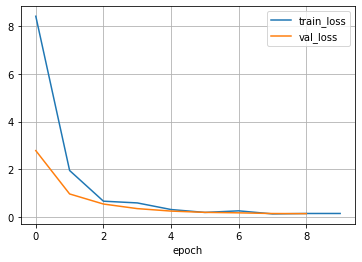

In [261]:
import pandas as pd 
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=20,
    callbacks=[model_checkpoint], # TODO 4
    logger=logger
  )

trainer.fit(model, train_dataloaders=dataloaders['train'], val_dataloaders=dataloaders['val'])
print(f"Logs stored at {logger.log_dir}/metrics.csv")


## Plot metrics
(
    pd.read_csv(f'{logger.log_dir}/metrics.csv') .groupby('epoch').mean()
    [['train_loss', 'val_loss']].plot(grid=True)
)

In [262]:
print(f"""
    Best model saved at {model_checkpoint.best_model_path}
    With validation loss {model_checkpoint.best_model_score}
""")

# Loading best model
best_model = LitForecast.load_from_checkpoint(model_checkpoint.best_model_path)


    Best model saved at logs/forecast_l63/version_34/checkpoints/epoch=8-step=2115.ckpt
    With validation loss 0.14750266075134277



In [263]:
### Explained variance for the convolutional auto-encoder
best_model.n_step_forecast = 29
trainer.test(best_model, dataloaders=dataloaders['test'])

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           3.4143035411834717
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 3.4143035411834717}]

In [264]:
out = stdTr * best_model.test_data[1] + meanTr
gt = stdTr * best_model.test_data[0] + meanTr
mse = np.sum( np.sum( (gt[:,:,1:best_model.n_step_forecast+1] - out)**2 , axis = 0 ) , axis=0 )
var = np.sum( np.sum( ( np.tile(gt[:,:,0].reshape(-1,3,1),(1,1,best_model.n_step_forecast)) - gt[:,:,1:best_model.n_step_forecast+1] )**2 , axis = 0 ) , axis= 0 )

var *= 1./(gt.shape[0]*3 )
mse *= 1./(gt.shape[0]*3 )

var_exp = 1. - mse / var

print('............................ ')
print('... Explained variance')
for _k in range(1,best_model.n_step_forecast):
  print('... dt = %d : %f '%(_k,var_exp[_k-1]))

............................ 
... Explained variance
... dt = 1 : 0.994502 
... dt = 2 : 0.994626 
... dt = 3 : 0.994735 
... dt = 4 : 0.994847 
... dt = 5 : 0.994930 
... dt = 6 : 0.994989 
... dt = 7 : 0.995031 
... dt = 8 : 0.995042 
... dt = 9 : 0.995016 
... dt = 10 : 0.994949 
... dt = 11 : 0.994849 
... dt = 12 : 0.994720 
... dt = 13 : 0.994567 
... dt = 14 : 0.994393 
... dt = 15 : 0.994202 
... dt = 16 : 0.993990 
... dt = 17 : 0.993754 
... dt = 18 : 0.993482 
... dt = 19 : 0.993162 
... dt = 20 : 0.992792 
... dt = 21 : 0.992366 
... dt = 22 : 0.991874 
... dt = 23 : 0.991304 
... dt = 24 : 0.990645 
... dt = 25 : 0.989888 
... dt = 26 : 0.989021 
... dt = 27 : 0.988030 
... dt = 28 : 0.986899 


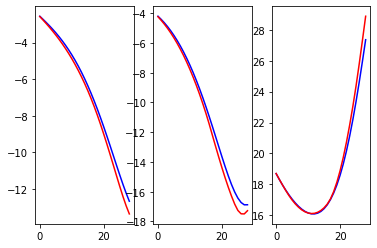

In [265]:
# test model for the considered time window
idx = 70
plt.figure(1)
for ii in range(3):
  plt.subplot(1,3,ii+1)
  plt.plot(gt[idx,ii,1:],'b')
  plt.plot(out[idx,ii,:],'r')


# Application to long-term simulation

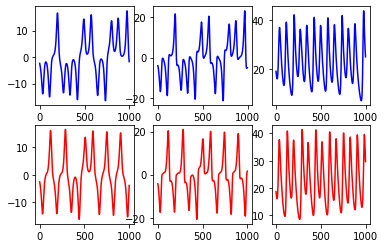

In [266]:
# simulation over a larger time window
Nstep = 1000#30000
X0 = torch.Tensor(X_test[idx,:,0]).view(1,3)

best_model.forecast_model = best_model.forecast_model.to(device)

# simulation with trained model
x0 = (X0 - meanTr) / stdTr
x0 = x0.to(device)
X_out = best_model.forecast_model(x0,n_step=Nstep)
X_out = X_out.detach() * stdTr + meanTr
X_out = X_out.cpu().numpy().squeeze()

# simulation with true OODE
X0 = X_test[idx,:,0]
X_ode = odeint(Lorenz_63, X0, np.arange(0.01,Nstep*dt,dt), args=(sigma,rho,beta))

plt.figure(1)
for ii in range(3):
  plt.subplot(2,3,ii+1)
  plt.plot(X_ode[Nstep-1000:Nstep,ii],'b')
  plt.subplot(2,3,3+ii+1)
  plt.plot(X_out[ii,Nstep-1000:Nstep],'r')


Text(0.5, 0.92, 'Prediction of Lorenz-63 trajectories')

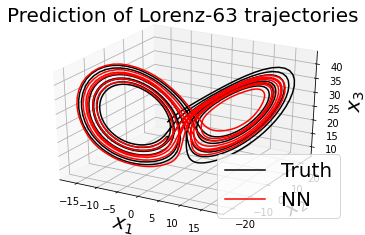

In [207]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
line1, = ax.plot(X_ode[:,0], X_ode[:,1], X_ode[:,2], 'k')
line2, = ax.plot(X_out[0,:], X_out[1,:], X_out[2,:], 'r')
ax.set_xlabel('$x_1$', size=20)
ax.set_ylabel('$x_2$', size=20)
ax.set_zlabel('$x_3$', size=20)
plt.legend([line1, line2], ['Truth','NN'], fontsize=20)
plt.title('Prediction of Lorenz-63 trajectories', size=20)